In [1]:
from langgraph.graph import StateGraph, END
from langchain.agents import tool
# from langchain_community.tools import ArxivAPIWrapper
from langchain_community.tools.arxiv.tool import ArxivAPIWrapper

from langchain_community.utilities import SerpAPIWrapper

from langchain_core.runnables import RunnableLambda
from langchain.chat_models import ChatOpenAI
from langchain.schema import Document
from langchain.output_parsers import PydanticOutputParser
import logging
import json

In [2]:

# Setup logging
logging.basicConfig(filename='logs.txt', level=logging.INFO)


In [3]:

# ------------------------
# Shared State Definition
# ------------------------
class ResearchState(dict):
    """
    A simple state container for the LangGraph workflow. Inherits from dict,
    so all state values are passed and updated as dictionary keys.
    Expected keys include:
        - input: str
        - plan: dict
        - docs: list
        - analysis: dict
        - report: str
    """
    input: str
    plan: dict
    docs: list
    analysis: dict
    report: str
    

In [4]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
# ------------------------
# Agents
# ------------------------

# 1. Research Planner
# @tool
def research_planner(input: str) -> dict:
    """Plans the research topic into goals and subtopics."""
    logging.info("Planning research for: %s", input)
    return {
        "topic": input,
        "objectives": [
            f"Define key terms in {input}",
            f"Survey recent papers related to {input}",
            f"Compare approaches and summarize insights"
        ]
    }

# 2. Information Gatherer

def info_gatherer(plan: dict) -> list:
    """Gathers documents using Arxiv and DuckDuckGo."""
    logging.info("Gathers documents using Arxiv and DuckDuckGo: %s", plan)

    
    arxiv = ArxivAPIWrapper()
    ddg = DuckDuckGoSearchRun()

    topic = plan.get("topic", "")
    arxiv_docs = arxiv.run(topic)
    web_docs = ddg.run(topic)

    documents = [
        Document(page_content=arxiv_docs, metadata={"source": "arxiv"}),
        Document(page_content=web_docs, metadata={"source": "web"})
    ]
    logging.info("Gathered %d documents", len(documents))
    return documents

# 3. Content Analyzer
# @tool
def content_analyzer(docs: list) -> dict:
    """Summarizes and analyzes documents."""
    logging.info("Summarizes and analyzes documents")

    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    texts = [doc.page_content[:1000] for doc in docs]  # Truncate for demo
    joined = "\n\n".join(texts)
    summary = model.invoke(f"Summarize and extract key insights:\n{joined}")
    title = model.invoke(f"give one word title for this summay, just one to two word, I have to set a file name:\n{summary}")
    title = title.content
    if len(title.split()) > 2:
        title = " ".join(title.split()[:2])
    logging.info("Analyzed %d documents", len(docs))
    return {"summary": summary, "title": title}

# 4. Report Generator
# @tool
def report_generator(analysis: dict) -> str:
    """Compiles the final report."""
    summary = analysis.get("summary", "No summary available.")
    title = analysis.get("title", "No title available.")
    report = f"=== Research Report ===\n\n{summary.content}"
    with open(f"{title}.txt", "w") as f:
        f.write(report)
    logging.info("Report written successfully.")
    return report

In [5]:
def safe_info_gatherer(state):
    try:
        docs = info_gatherer(state["plan"])
        return {**state, "docs": docs, "retries": state.get("retries", 0)}
    except Exception as e:
        logging.error("Error during gathering: %s", str(e))
        return {**state, "error": str(e), "retries": state.get("retries", 0) + 1}

def safe_content_analyzer(state):
    try:
        analysis = content_analyzer(state["docs"])
        return {**state, "analysis": analysis, "retries": state.get("retries", 0)}
    except Exception as e:
        logging.error("Error during analysis: %s", str(e))
        return {**state, "error": str(e), "retries": state.get("retries", 0) + 1}


In [6]:
def handle_error(state):
    logging.error("Final failure: %s", state.get("error", "Unknown error"))
    return {**state, "final_status": "error"}


In [7]:
def human_review(state: dict) -> dict:
    """Pause for human approval of analysis before generating the report."""
    print("\n--- HUMAN REVIEW REQUIRED ---")
    print("Summary:\n", state["analysis"].get("summary", "No summary"))
    approval = input("Approve summary? (yes/no): ").strip().lower()
    
    if approval == "yes":
        state["approved"] = True
    else:
        state["approved"] = False
    return state


In [8]:
from langgraph.graph import END, StateGraph
from langchain_core.runnables import RunnableLambda

# ------------------------
# LangGraph Construction
# ------------------------

builder = StateGraph(ResearchState)

# --- Main Agent Nodes ---

builder.add_node("planner", RunnableLambda(
    lambda state: {**state, "plan": research_planner(state["input"])}
))

builder.add_node("gatherer", RunnableLambda(
    lambda state: safe_info_gatherer(state)
))

builder.add_node("analyzer", RunnableLambda(
    lambda state: safe_content_analyzer(state)
))

builder.add_node("generator", RunnableLambda(
    lambda state: {**state, "report": report_generator(state["analysis"])}
))
builder.add_node("human_review", RunnableLambda(human_review))

# --- Error Handling Nodes ---

builder.add_node("error_handler", RunnableLambda(
    lambda state: handle_error(state)
))

builder.add_node("retry_gatherer", RunnableLambda(
    lambda state: {**state, "docs": info_gatherer(state["plan"])}
))

builder.add_node("retry_planner", RunnableLambda(
    lambda state: {**state, "plan": research_planner(state["input"] + " refined")}
))

# --- Entry Point ---

builder.set_entry_point("planner")

# --- Normal Flow ---

builder.add_edge("planner", "gatherer")

# --- Conditional Edge After Gathering ---

builder.add_conditional_edges(
    "gatherer",
    lambda state: (
        "analyzer" if state.get("docs")
        else "retry_planner" if state.get("retries", 0) < 1
        else "error_handler"
    )
)

builder.add_edge("retry_planner", "gatherer")

# --- Conditional Edge After Analyzing ---

# builder.add_conditional_edges(
#     "analyzer",
#     lambda state: (
#         "generator" if state.get("analysis", {}).get("summary")
#         else "retry_gatherer" if state.get("retries", 0) < 2
#         else "error_handler"
#     )
# )
builder.add_conditional_edges(
    "analyzer",
    lambda state: (
        "human_review" if state.get("analysis", {}).get("summary")
        else "retry_gatherer" if state.get("retries", 0) < 2
        else "error_handler"
    )
)

builder.add_conditional_edges(
    "human_review",
    lambda state: "generator" if state.get("approved") else "error_handler"
)


builder.add_edge("retry_gatherer", "analyzer")

builder.add_edge("generator", END)
builder.add_edge("error_handler", END)

# --- Compile ---

graph = builder.compile()


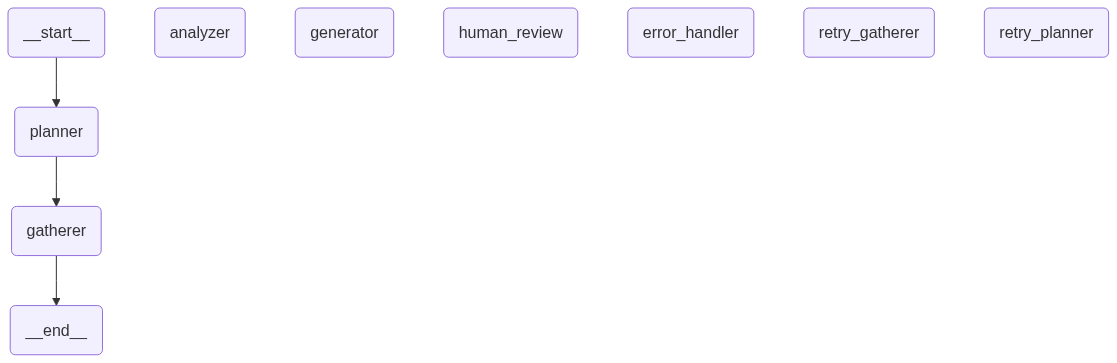

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = openai_api_key

In [12]:
topic = "AI in Climate Modeling"
state = ResearchState()
state["input"] = topic
results = graph.invoke(state)
print("\nFinal Report Output:\n")
print(results)
# print("\nWorkflow complete. Report saved as 'final_report.txt'.")



Final Report Output:

{'input': 'AI in Climate Modeling', 'plan': {'topic': 'AI in Climate Modeling', 'objectives': ['Define key terms in AI in Climate Modeling', 'Survey recent papers related to AI in Climate Modeling', 'Compare approaches and summarize insights']}}
